<a href="https://colab.research.google.com/github/iyqht/simple-neural-network/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 198kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


In [4]:
test_data = datasets.MNIST(root='mnist_data', train=False, transform=transform, download=True)

In [5]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 9, 3, 1)
    self.conv2 = nn.Conv2d(9, 20, 3, 1)
    self.fc1 = nn.Linear(5 * 5 * 20, 84)
    self.fc2 = nn.Linear(84, 120)
    self.fc3 = nn.Linear(120, 84)
    self.fc4 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 20 * 5 * 5)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = F.relu(self.fc3(X))
    X = self.fc4(X)
    return F.log_softmax(X, dim = 1)

In [7]:
torch.manual_seed(41)
model = ConvolutionalNetwork()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 5
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  for b,(X_train, y_train) in enumerate(train_loader):
    b += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%800 == 0:
      print(f'epoch: {i}  loss: {loss.item()}  accuracy: {trn_corr.item()*100/(10*b)}%')

  train_losses.append(loss.item())
  train_correct.append(trn_corr)

  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr = (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss.item())
  test_correct.append(tst_corr)

epoch: 0  loss: 0.7335541844367981  accuracy: 79.2%
epoch: 0  loss: 0.2825021743774414  accuracy: 86.5375%
epoch: 0  loss: 0.08677954971790314  accuracy: 89.6625%
epoch: 0  loss: 0.015547297894954681  accuracy: 91.30625%
epoch: 0  loss: 0.0022596726194024086  accuracy: 92.3875%
epoch: 0  loss: 0.010188539512455463  accuracy: 93.15208333333334%
epoch: 0  loss: 0.0056448765099048615  accuracy: 93.78928571428571%
epoch: 1  loss: 0.1125541478395462  accuracy: 97.6625%
epoch: 1  loss: 0.0009554365533404052  accuracy: 97.6375%
epoch: 1  loss: 0.002182638505473733  accuracy: 97.63333333333334%
epoch: 1  loss: 0.001292619970627129  accuracy: 97.759375%
epoch: 1  loss: 0.014581173658370972  accuracy: 97.865%
epoch: 1  loss: 0.048263393342494965  accuracy: 97.92083333333333%
epoch: 1  loss: 0.9720934629440308  accuracy: 97.97857142857143%
epoch: 2  loss: 0.0008040698012337089  accuracy: 98.275%
epoch: 2  loss: 0.0020605793688446283  accuracy: 98.45625%
epoch: 2  loss: 0.01237604022026062  accura

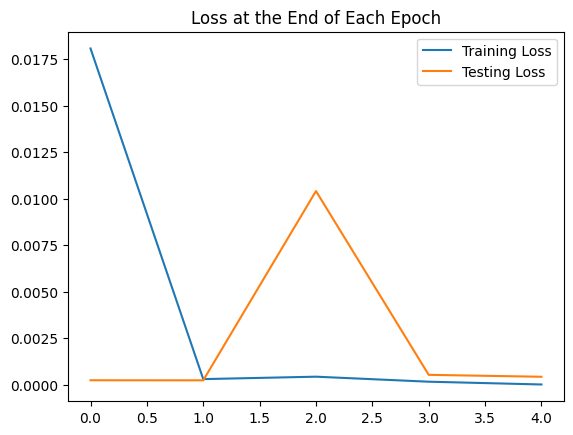

In [13]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at the End of Each Epoch')
plt.legend()

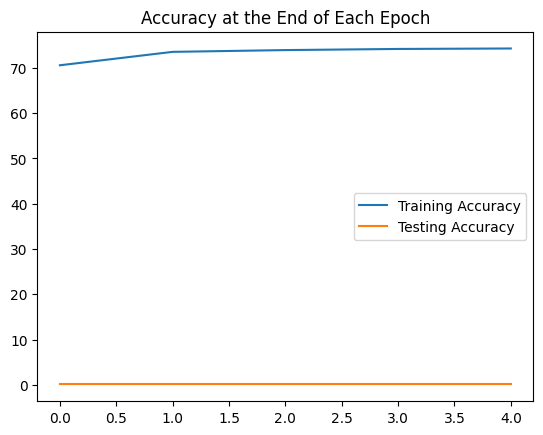

In [14]:
plt.plot([t/800 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at the End of Each Epoch')
plt.legend()

In [15]:
all_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

In [16]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in all_loader:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

print(f'Test Accuracy: {correct.item()/len(test_data)*100}%')

Test Accuracy: 98.71%


In [17]:
torch.save(model.state_dict(), "my_model.pth")

In [18]:
my_model = ConvolutionalNetwork()
my_model.load_state_dict(torch.load("my_model.pth"))

<All keys matched successfully>

In [19]:
my_model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(9, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)

Predicted: "3", Actual: "3"


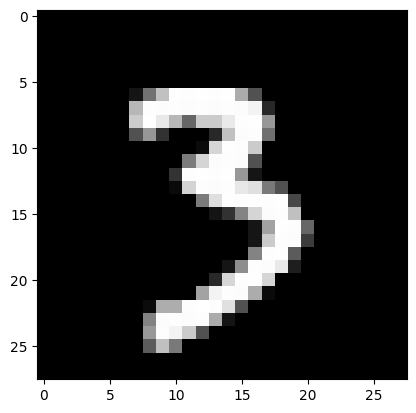

In [20]:
classes = [str(i) for i in range(10)]

sample = 30
x,y = test_data[sample][0], test_data[sample][1]

with torch.no_grad():
  pred = my_model(x)

  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')
  plt.imshow(x.squeeze(), cmap='gray')

In [21]:
!pip install gdown

In [22]:
#collapse-output
import gdown
url = "https://drive.google.com/drive/folders/1c1fLCOq6_iq_ZnhbhTkTbHvbjzupnFb0?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/digit/0.jpg',
 '/content/digit/1.jpg',
 '/content/digit/2.jpg',
 '/content/digit/3.jpg',
 '/content/digit/4.jpg',
 '/content/digit/5.jpg',
 '/content/digit/6.jpg',
 '/content/digit/7.jpg',
 '/content/digit/8.jpg',
 '/content/digit/9.jpg']

Predicted: "5", Actual: "0"


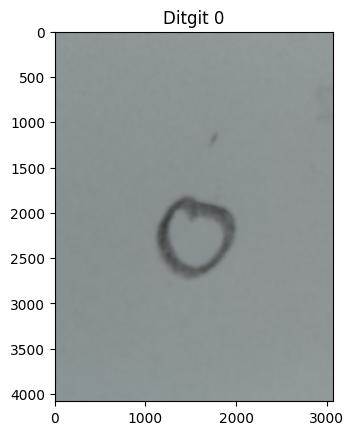



Predicted: "1", Actual: "1"


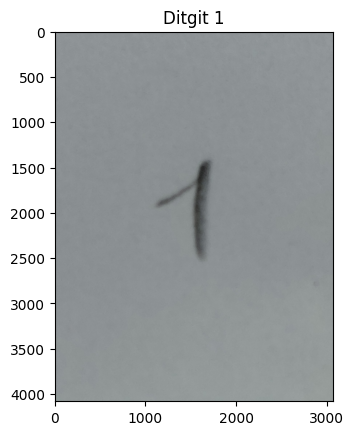



Predicted: "5", Actual: "2"


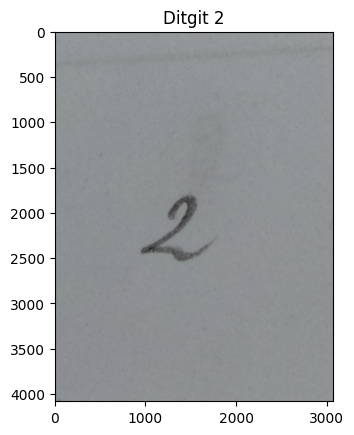



Predicted: "1", Actual: "3"


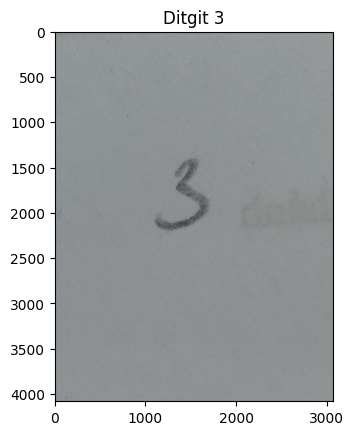



Predicted: "4", Actual: "4"


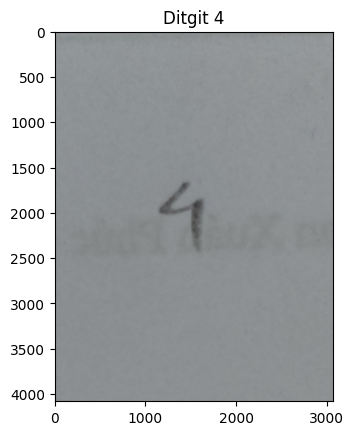



Predicted: "5", Actual: "5"


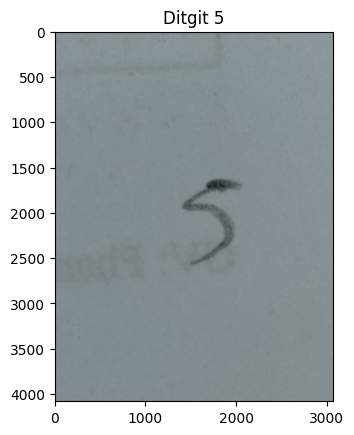



Predicted: "6", Actual: "6"


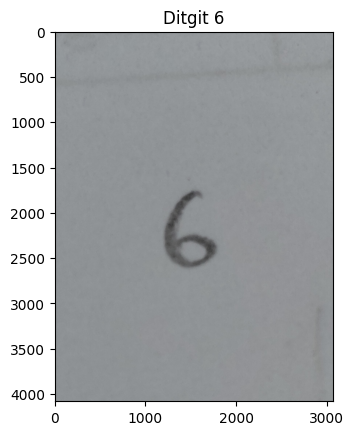



Predicted: "1", Actual: "7"


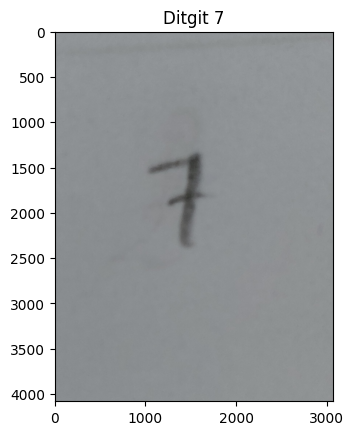



Predicted: "1", Actual: "8"


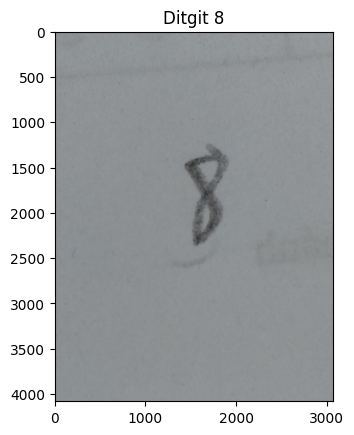



Predicted: "2", Actual: "9"


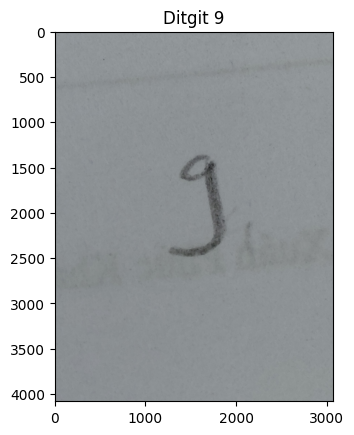



Correct: 4
Incorrect: 6


In [38]:
from PIL import Image

transform = transforms.Compose([
    transforms.CenterCrop(38*38),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
])

classes = [str(i) for i in range(10)]
correct = 0
incorrect = 0

for i in range(10):
  image = Image.open('/content/digit/' + str(i) + '.jpg')

  img_tensor = transform(image)
  img_tensor = transforms.functional.invert(img_tensor)
  img_tensor = transforms.functional.adjust_contrast(img_tensor, 1.5)
  img_tensor = transforms.functional.adjust_brightness(img_tensor, 1.5)

  with torch.no_grad():
    pred = my_model(img_tensor)

    predicted, actual = classes[pred[0].argmax(0)], classes[i]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    if (predicted == actual):
      correct += 1
    else:
      incorrect += 1

    plt.title("Ditgit " + str(i))
    plt.imshow(image)
    plt.show()
    print('\n')

print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")